In [17]:
import pandas as pd

In [18]:
import h5py
import pywt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import sys
sys.path.append('../')
import utils_ecg.get_ecg as ge
import utils_ecg.read_ecg as re
#import features as ft


## The prediction data frame

In [19]:
dnn_annotations = pd.read_csv("../dnn_files/data/annotations/dnn.csv") #df as in Data Frame
print(dnn_annotations)

     Unnamed: 0  1dAVb  RBBB  LBBB  SB  AF  ST
0             0      0     0     0   0   0   0
1             1      0     0     1   0   0   0
2             2      0     0     0   0   0   0
3             3      0     0     0   0   0   0
4             4      0     0     0   0   0   0
..          ...    ...   ...   ...  ..  ..  ..
822         822      0     0     0   0   0   0
823         823      0     0     0   0   0   0
824         824      0     0     0   0   0   0
825         825      0     0     0   0   0   0
826         826      1     0     0   0   0   0

[827 rows x 7 columns]


In [20]:
dnn_annotations['SB'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## The raw ECGs

In [21]:
def is_only_zero(li):
    return (np.sum(np.abs(li)<0.0001)==len(li))

print('is_only_zero([0,-1,1]) : '+str(is_only_zero([0,-1,1])))
print('is_only_zero([0.0000000001,-0.000000000003,0]) : '+str(is_only_zero([0.0000000001,-0.000000000003,0])))

is_only_zero([0,-1,1]) : False
is_only_zero([0.0000000001,-0.000000000003,0]) : True


In [22]:
def has_dead_lead(lili): #shape = (p,t)
    (p,t) = np.shape(lili)
    verdict = False
    for lead in range(p):
        verdict = verdict or is_only_zero(lili[lead])
    return verdict

#un signal temporel se lit en ligne, chaque ligne étant un 'lead' = une piste
test1 = np.array([[1,0,3],[0,0,1],[0,0,0]])
test2 = np.array([[1,2,3],[0,-1,1],[0,1,0]])
print('has_dead_lead(test1) : '+str(has_dead_lead(test1)))
print('has_dead_lead(test2) : '+str(has_dead_lead(test2)))

has_dead_lead(test1) : True
has_dead_lead(test2) : False


In [23]:
def get_clean_ecg(tracings_file="../dnn_files/data/ecg_tracings.hdf5"):
    with h5py.File(tracings_file, "r") as f:
        ecg_tracings = np.swapaxes(np.array(f['tracings']),1,2) #shape = (827,12,4096)
        bad_indexes = []
        for i in range(827):
            if has_dead_lead(ecg_tracings[i]):
                bad_indexes+=[i]
        ecg_tracings = np.delete(ecg_tracings, bad_indexes,0) #Isolate and delete the bad indexes
    return (bad_indexes,np.array([[re.delete_zeros(ecg[lead]) for lead in range(12)] for ecg in ecg_tracings])) #delete zeroes
(bad_indexes,table_ecg) = get_clean_ecg()
print(np.shape(table_ecg))
print(bad_indexes)

(813, 12)
[177, 251, 269, 321, 323, 385, 434, 446, 537, 542, 575, 601, 784, 790]


shape of table_ecg : (813, 12)


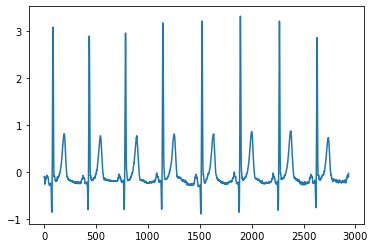

In [24]:
print('shape of table_ecg : '+str(np.shape(table_ecg)))
plt.plot(table_ecg[0][0])
plt.show()

In [25]:
list_ecg_0lead = table_ecg[:,0]
list_ecg_6lead = table_ecg[:,6]
list_ecg_7lead = table_ecg[:,7]
list_ecg_8lead = table_ecg[:,8]
list_ecg_9lead = table_ecg[:,9]
list_ecg_10lead = table_ecg[:,10]
list_ecg_11lead = table_ecg[:,11]

In [26]:
avgs_of_leads_0 = np.array([np.mean(list_ecg_0lead[k]) for k in range(np.shape(list_ecg_0lead)[0])])
print(len(avgs_of_leads_0))

813


In [27]:
dnn_annotations

,Unnamed: 0,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0
2,2,0,0,0,0,0,0
3,3,0,0,0,0,0,0
4,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...
822,822,0,0,0,0,0,0
823,823,0,0,0,0,0,0
824,824,0,0,0,0,0,0
825,825,0,0,0,0,0,0


In [28]:
dnn_annotations = dnn_annotations.drop(bad_indexes)

In [32]:
series={"moyenne0":avgs_of_leads_0,"moyenne1":avgs_of_leads_0}
pd.DataFrame(series)

,moyenne0,moyenne1
0,0.000694,0.000694
1,-0.169633,-0.169633
2,0.002154,0.002154
3,-0.001981,-0.001981
4,0.002119,0.002119
...,...,...
808,0.003140,0.003140
809,0.005104,0.005104
810,0.012788,0.012788
811,0.002781,0.002781


In [33]:
print(series["moyenne0"])

[ 6.93903999e-04 -1.69633079e-01  2.15390494e-03 -1.98050539e-03
  2.11918869e-03  7.43713302e-04 -8.95291922e-04 -8.37502139e-03
 -2.29421445e-03  1.87143147e-02 -8.66002605e-03  4.40976482e-01
 -2.16685413e-03  5.12391062e-04  1.87687069e-03 -1.62606013e-02
  4.76783483e-03  6.06410088e-01  1.44086110e-01  2.22318794e-03
 -4.83318997e-02  4.20779418e-01 -7.76227389e-03  1.54076433e-03
  5.78673689e-03 -2.13103227e-04  1.89642626e-01 -3.90202673e-01
  1.22660076e-01  1.82157061e-01 -1.71492569e-01 -7.63136081e-01
  6.63418967e-02  2.94854324e-03  3.00512916e-03  6.97843609e-04
  3.39859144e-03  4.43038953e-03  1.07331606e+00  3.96528728e-03
 -6.43635267e-01  2.96324189e-01 -6.51618813e-05  4.43892802e-03
  5.14624232e-03  4.06468167e-01 -1.27585613e+00 -1.03534685e-03
  2.87844738e-03  1.29739042e-03  1.78005747e-03 -4.42404938e-01
 -2.13654375e-03  2.94718798e-03  1.51280240e-03  3.24865930e-04
 -1.09171803e-03  6.04953702e-03  8.34675406e-03  9.54783014e-01
 -5.43421116e-01 -2.35713

In [34]:
def delete_zeros(ecg):
    """Delete the first and the last occurences of zero in the ecg"""
    temp = ecg[np.where(np.abs(np.array(ecg)) > 10 ** (-6))[0][0]:]
    print(temp)
    return temp[:np.where(np.abs(np.array(temp)) > 10 ** (-6))[-1][-1]]

a=np.array([0,0,0,1,2,2,-1,0,0])
b=np.array([0,1,3,-2,1,0,0,0])
ab = np.array([a,b])
#delete_zeros(a)